In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv, save_to_json, save_bundle

from const import STATE, COLORS, NUM_STATES,  STATES


In [3]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')

In [4]:
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)
bed_info = pkl.load(open('data/bed_info.pkl', 'rb'))

In [5]:
total_days =  360

In [6]:
def one_run(delta_t, total_days=360):
    delta = timedelta(days=delta_t)
    assumed_ld_date = lockdown_time + delta
    days_to_p0 = (assumed_ld_date - p0_time).days
    print('lockdown date',  assumed_ld_date)
    params = Params(
        total_population=params_before.total_population,
        initial_num_E=params_before.initial_num_E,
        initial_num_I=params_before.initial_num_I,
        initial_num_M=params_before.initial_num_M,    
        alpha=[(0, params_before.alpha), (days_to_p0, params_after.alpha)],
        beta=[(0, params_before.beta), (days_to_p0, params_after.beta)],
        mu_ei=params_after.mu_ei,
        mu_mo=params_after.mu_mo,
        k_days=params_after.k_days,
        x0_pt=params_after.x0_pt,          
        stages=[days_to_p0]
    )
    
    total, delta, increase, trans, stats = do_simulation(total_days, bed_info, params, p0_time=p0_time)
    bundle = [total, delta, increase, trans]
    return assumed_ld_date, delta_t, bundle, stats

In [7]:
rows = Parallel(n_jobs=-1)(delayed(one_run)(delta_t, total_days) for  delta_t in range(-7, 8))

-7
2020-01-16
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']


/home/cloud-user/code/covid-19/helpers.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['index'] = df.index
/home/cloud-user/code/covid-19/helpers.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['value'] = subdf[state].copy()
/home/cloud-user/code/covid-19/helpers.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

-6
2020-01-17
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
-5
2020-01-18
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
-4
2020-01-19
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
-3
2020-01-20
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
-2
2020-01-21
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
-1
2020-01-22
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
0
2020-01-23
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
1
2020-01-24
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
2
2020-01-25
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
3
2020-01-26
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
4
2020-01-27
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
5
2020-01-28
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
6
2020-01-29
['29/11/1

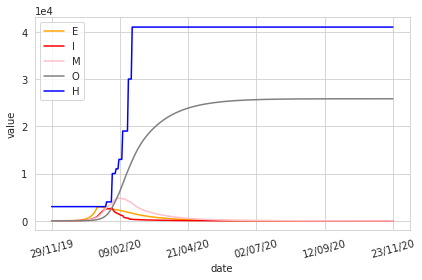

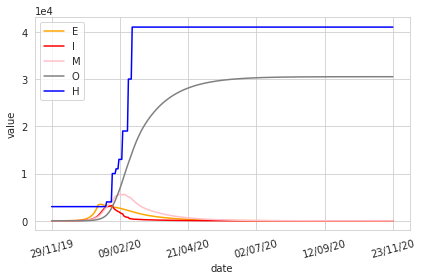

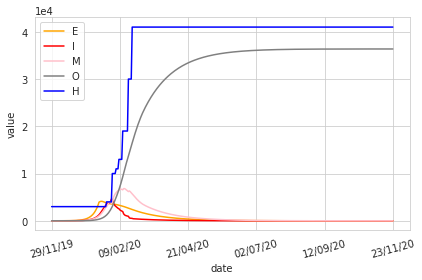

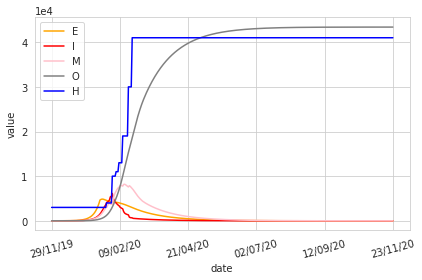

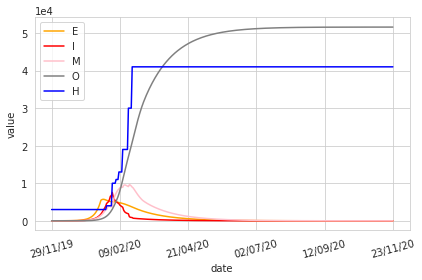

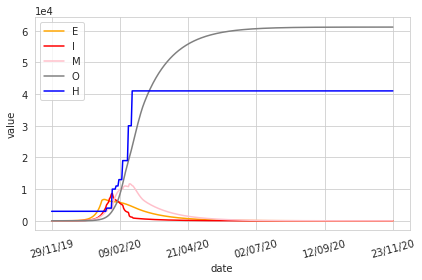

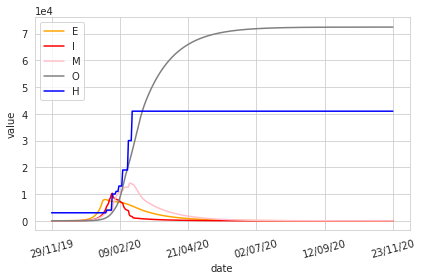

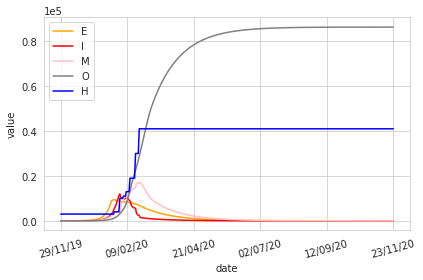

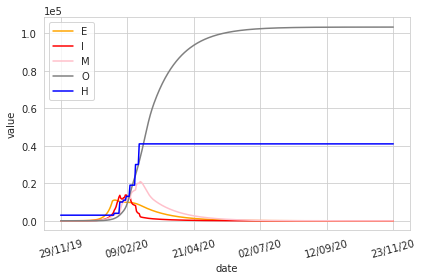

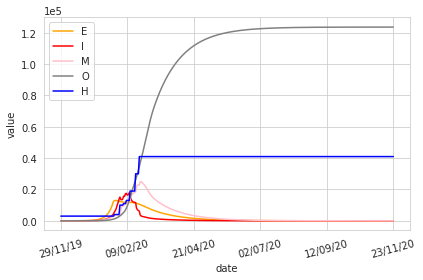

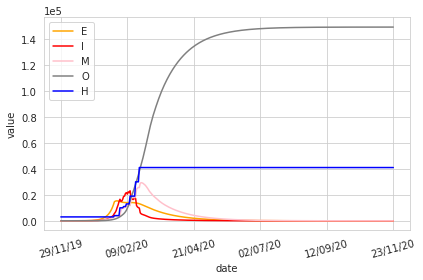

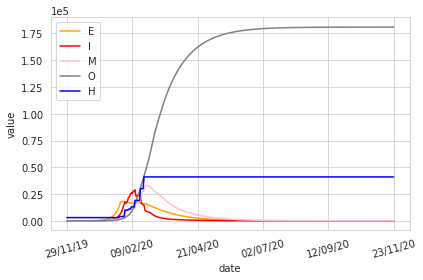

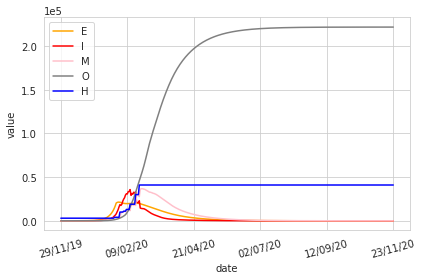

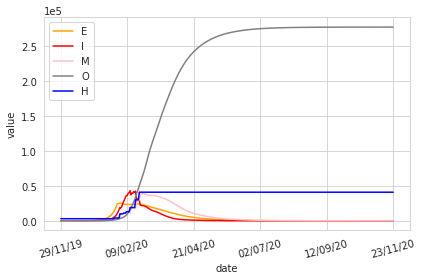

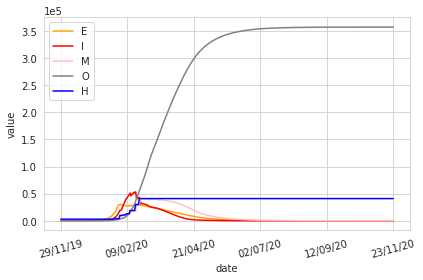

In [8]:
for dt, days, bundle, stats in rows:
    dt_str = dt.strftime('%Y-%m-%d')
    print(days)
    print(dt_str)
    fig, ax = plot_total(bundle[0], p0_time, total_days)
    fig.savefig(f'figs/advance-or-delay-lockdown/{dt_str}({days}).pdf')

    save_bundle(bundle, p0_time, total_days, f'output/tbl/advance-or-delay-lockdown/{dt_str}-({days})/')
    save_to_json(stats, f'output/tbl/advance-or-delay-lockdown/{dt_str}-({days})/stats.txt')